Please draw rectangles on the first image to select the ROIs.
ROI selected: (222, 430, 568, 788)
ROI selected: (116, 304, 1098, 1286)
ROI selected: (232, 482, 1514, 1734)
ROI selected: (588, 796, 762, 976)


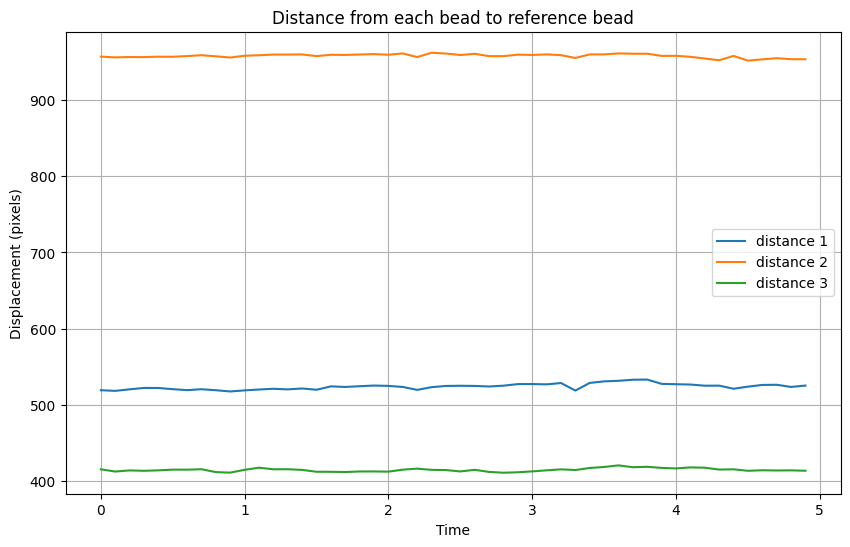

In [2]:
import numpy as np
from scipy.ndimage import center_of_mass
from PIL import Image
import cv2
import glob
import os
import matplotlib.pyplot as plt

# 调节阈值
threshold_constant = 1.4

# 时间间隔
time_interval = 0.1

# 文件夹路径
image_folder = "C:\\Users\\PC\\Desktop\\final year project\\pictures\\20250119"

# 存储所有图片的距离
output_distances = []  # 用于存储每个 ROI 到基准 ROI 的距离

# 加载文件夹中的所有图片（假设文件夹中只有图片文件）
image_files = glob.glob(os.path.join(image_folder, "*.png"))
image_files = image_files[:50]

# 检查是否有图片
if not image_files:
    raise ValueError("No images found in the folder.")

# 存储选中的点坐标
rois = []

# 缩放比例
scale = 0.5  # 图像缩小到 50%

# OpenCV 鼠标回调函数
def select_rois(event, x, y, flags, param):
    """
    OpenCV 鼠标回调函数，用于选择矩形区域的坐标。
    """
    global rois, drawing, ix, iy

    if event == cv2.EVENT_LBUTTONDOWN:  # 鼠标左键按下
        drawing = True
        ix, iy = x, y  # 记录起始点

    elif event == cv2.EVENT_LBUTTONUP:  # 鼠标左键释放
        drawing = False
        # 将坐标转换为原始图像的坐标
        x_original = int(x / scale)
        y_original = int(y / scale)
        ix_original = int(ix / scale)
        iy_original = int(iy / scale)
        # 记录 ROI 的坐标 (y_min, y_max, x_min, x_max)
        rois.append((min(iy_original, y_original), max(iy_original, y_original), 
                     min(ix_original, x_original), max(ix_original, x_original)))
        print(f"ROI selected: {rois[-1]}")
        # 在原始图像上绘制矩形
        cv2.rectangle(original_image, (ix_original, iy_original), (x_original, y_original), (0, 255, 0), 2)
        # 更新显示图像
        resized_image = cv2.resize(original_image, (0, 0), fx=scale, fy=scale)
        cv2.imshow("Select ROIs", resized_image)

# Step 1: 在第一张图片上选择 ROI
print("Please draw rectangles on the first image to select the ROIs.")
first_image_path = image_files[0]
first_image = Image.open(first_image_path).convert("L")  # 转换为灰度图像
first_image_array = np.array(first_image)

# 将图像转换为 OpenCV 格式（BGR）
original_image = cv2.cvtColor(first_image_array, cv2.COLOR_GRAY2BGR)

# 调整图像大小
resized_image = cv2.resize(original_image, (0, 0), fx=scale, fy=scale)

# 创建窗口并绑定鼠标回调函数
cv2.namedWindow("Select ROIs", cv2.WINDOW_NORMAL)
cv2.setMouseCallback("Select ROIs", select_rois)

# 显示图像并等待用户选择 ROI
while True:
    cv2.imshow("Select ROIs", resized_image)
    key = cv2.waitKey(1) & 0xFF
    if key == 27:  # 按下 ESC 键退出
        break
    if key == 13:  # 按下回车键确认选择完成
        if len(rois) >= 2:  # 至少选择两个 ROI
            break
        else:
            print("Please select at least two ROIs.")

cv2.destroyAllWindows()

# 检查是否选择了至少两个 ROI
if len(rois) < 2:
    raise ValueError("Please select at least two ROIs.")

# 提取基准 ROI 和其他 ROI 的坐标
base_roi = rois[0]  # 第一个 ROI 作为基准
other_rois = rois[1:]  # 其他 ROI

# Step 2: 对文件夹中的所有图片进行处理
for one_image_path in image_files:
    # 加载图片并转换为灰度图像
    image = Image.open(one_image_path).convert("L")
    image_array = np.array(image)

    # 提取基准 ROI
    base_roi_array = image_array[base_roi[0]:base_roi[1], base_roi[2]:base_roi[3]]
    # 对基准 ROI 进行二值化处理
    base_threshold = np.mean(base_roi_array) + threshold_constant * np.std(base_roi_array)
    base_roi_binary = base_roi_array > base_threshold
    # 计算基准 ROI 的质心
    base_centroid = center_of_mass(base_roi_binary)
    base_centroid_global = (base_centroid[0] + base_roi[0], base_centroid[1] + base_roi[2])

    # 存储当前图片中其他 ROI 到基准 ROI 的距离
    distances = []
    for roi in other_rois:
        # 提取当前 ROI
        roi_array = image_array[roi[0]:roi[1], roi[2]:roi[3]]
        # 对当前 ROI 进行二值化处理
        threshold = np.mean(roi_array) + threshold_constant * np.std(roi_array)
        roi_binary = roi_array > threshold
        # 计算当前 ROI 的质心
        centroid = center_of_mass(roi_binary)
        centroid_global = (centroid[0] + roi[0], centroid[1] + roi[2])
        # 计算当前 ROI 质心到基准 ROI 质心的距离
        distance = np.sqrt((centroid_global[0] - base_centroid_global[0])**2 +
                           (centroid_global[1] - base_centroid_global[1])**2)
        distances.append(distance)

    # 将距离保存到数组中
    output_distances.append(distances)

# 将距离数据转换为 NumPy 数组
output_distances = np.array(output_distances)

# 创建时间轴
time_points = np.linspace(0, time_interval * (len(image_files) - 1), len(image_files))

# 分别绘制每个 ROI 到基准 ROI 的距离
plt.figure(figsize=(10, 6))
for i in range(len(other_rois)):
    plt.plot(time_points, output_distances[:, i], label=f'distance {i+1}')

plt.xlabel('Time')
plt.ylabel('Displacement (pixels)')
plt.title('Distance from each bead to reference bead')
plt.legend()
plt.grid(True)
plt.show()